In [19]:
import pandas as pd
import boto3
import sagemaker
import json
import numpy as np
import os
import pickle

In [20]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# name of S3 bucket and directory of data contained
bucket = 'sagemaker-us-east-1-539912551364'
prefix = 'retail_trading'

# connect to S3
conn = boto3.client('s3')

In [21]:
# Load map from transitions to posts and post text data
def load_post_mappings():
    trailing_days = [3, 5, 10]
    
    train_mappings = dict()
    test_mappings = dict()
    
    for day in trailing_days:
        train_response = conn.get_object(Bucket=bucket, Key='{}-day-example-map-train.json'.format(day))
        test_response = conn.get_object(Bucket=bucket, Key='{}-day-example-map-test.json'.format(day))
        
        train_mappings[day] = json.load(train_response['Body'])
        test_mappings[day] = json.load(test_response['Body'])
        
    return train_mappings, test_mappings

def load_posts():
    # expanded df maps tickers to comments containing them
    expanded_response = conn.get_object(Bucket=bucket, Key='expanded cleaned posts.csv')
    expanded_df = pd.read_csv(expanded_response['Body'], index_col=[0])
    
    # compressed dfs contain cleaned text that can be related to train/test mappings with hash keys
    test_X_response = conn.get_object(Bucket=bucket, Key='compressed_test_X_df.csv')
    test_X_df = pd.read_csv(test_X_response['Body'], index_col=[0])
    test_X_df['text'] = test_X_df['text'].astype(str)
    
    train_X_response = conn.get_object(Bucket=bucket, Key='compressed_train_X_df.csv')
    train_X_df = pd.read_csv(train_X_response['Body'], index_col=[0])
    train_X_df['text'] = train_X_df['text'].astype(str)
    
    return expanded_df, test_X_df, train_X_df

train_mappings, test_mappings = load_post_mappings()
expanded_df, test_X_df, train_X_df = load_posts()

assert train_mappings[3][0]['target_samples'] in train_X_df.text_hash.values
assert train_mappings[3][0]['random_samples'][0] in train_X_df.text_hash.values
assert test_mappings[3][0]['target_samples'] in test_X_df.text_hash.values
assert test_mappings[3][0]['random_samples'][0] in test_X_df.text_hash.values

In [22]:
def build_dict(data, vocab_size = 5000):
    """
    As in the course project, we'll construct a dictionary mapping of the most frequently appearing
    words to a unique integer. Once again, we'll reserve entries for the 'no-word' and 'infrequent'
    labels.
    """
    
    # Determine how often each word appears in `data`.
    word_count = {}
    for post in data:
        for word in post.split():
            
            if word in word_count.keys():
                word_count[word] += 1
            else:
                word_count[word] = 1
    
    # Sort the words found in `data` so that sorted_words[0] is the most frequently appearing word and
    # sorted_words[-1] is the least frequently appearing word.
    sorted_words = sorted(list(word_count.keys()), 
                          key = lambda x: word_count[x],
                          reverse = True)
    
    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): # The -2 is so that we save room for the 'no word'
        word_dict[word] = idx + 2                              # 'infrequent' labels
        
    return word_dict

# Only use posts from the training dataset 
word_dict = build_dict(train_X_df.text.values)

In [23]:
# Print the top ten words by frequency rank - looks pretty good!
rank_to_word = {rank: word for word, rank in word_dict.items()}
for rank in range(1, 11):
    key = rank + 1
    print('Rank: {} Word: {}'.format(rank, rank_to_word[key]))

Rank: 1 Word: earn
Rank: 2 Word: call
Rank: 3 Word: stock
Rank: 4 Word: buy
Rank: 5 Word: go
Rank: 6 Word: like
Rank: 7 Word: market
Rank: 8 Word: trade
Rank: 9 Word: put
Rank: 10 Word: get


In [24]:
# Save word dict 
data_dir = '../data/final-project'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
with open(os.path.join(data_dir, 'word_dict.pkl'), "wb") as f:
    pickle.dump(word_dict, f)

In [25]:
def convert_and_pad(word_dict, post, pad=500):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_post = [NOWORD] * pad
    split_post = post.split()
    for word_index, word in enumerate(split_post[:pad]):
        if word in word_dict:
            working_post[word_index] = word_dict[word]
        else:
            working_post[word_index] = INFREQ
            
    return working_post, min(len(split_post), pad)

def convert_and_pad_data(word_dict, post_mappings, text_df, pad=500):
    compound_text = []
    transition = []
    lengths = []
    idxs = []
    nskipped = 0
    
    for idx, mapping in enumerate(post_mappings):
        if len(set(mapping['random_samples'])) < 3:
            # This is hackey but it looks like I forgot to make sure the example
            # sampling procedure sampled withouth replacement
            nskipped += 1
            continue
        
        target_post = text_df.loc[text_df['text_hash'] == mapping['target_samples'], 'text'].values
        random_posts = text_df.loc[text_df['text_hash'].isin(mapping['random_samples']), 'text'].values
        
        converted_target, leng = convert_and_pad(word_dict, target_post[0], pad)
        converted_random, lengs = zip(*[convert_and_pad(word_dict, post, pad) for post in random_posts])
        
        compound_text.append(np.concatenate([converted_target] + list(converted_random)).reshape(1, -1))
        transition.append(int(mapping['transition']))
        lengths.append([leng] + list(lengs))
        idxs.append(idx)
        
    print("Number skipped due to repeats: {}".format(nskipped))
    return {
        'X': np.vstack(compound_text),
        'y': np.array(transition),
        'length': np.array(lengths),
        'index': np.array(idxs)
    }

train_data = dict()
test_data = dict()
for lag in [3, 5, 10]:
    print('Converting Examples For Lag {}:'.format(lag))
    print('Test Set...')
    test_data[lag] = convert_and_pad_data(word_dict, test_mappings[lag], test_X_df)
    print('Train Set...')
    train_data[lag] = convert_and_pad_data(word_dict, train_mappings[lag], train_X_df)



Converting Examples For Lag 3:
Test Set...
Number skipped due to repeats: 12
Train Set...
Number skipped due to repeats: 68
Converting Examples For Lag 5:
Test Set...
Number skipped due to repeats: 2
Train Set...
Number skipped due to repeats: 67
Converting Examples For Lag 10:
Test Set...
Number skipped due to repeats: 7
Train Set...
Number skipped due to repeats: 43


In [28]:
# Upload the data to S3    

for lag in [3, 5, 10]:
    (
        pd.concat([pd.DataFrame(train_data[lag]['y']),
                   pd.DataFrame(train_data[lag]['length']),
                   pd.DataFrame(train_data[lag]['X'])], 
                  axis = 1)
        .to_csv(os.path.join(data_dir, 'lag_{}_train.csv'.format(lag)),
                header = False,
                index = False)
    )
    (
        pd.concat([pd.DataFrame(test_data[lag]['y']),
                   pd.DataFrame(test_data[lag]['length']),
                   pd.DataFrame(test_data[lag]['X'])], 
                  axis = 1)
        .to_csv(os.path.join(data_dir, 'lag_{}_test.csv'.format(lag)),
                header = False,
                index = False)
    )
    

In [29]:
prefix = 'sagemaker/sentiment_rnn'
data_dir = '../data/final-project'
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

In [30]:
import torch
import torch.utils.data
import torch.optim as optim
from source_pytorch.model import LSTMClassifier

# Read in only the first 250 rows
train_sample = pd.read_csv(os.path.join(data_dir, 'lag_{}_train.csv'.format(3)), header=None, names=None, nrows=250)

# Turn the input pandas dataframe into tensors
train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()
train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).long()

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=50)

In [31]:
# write the training method
def train(model, train_loader, epochs, optimizer, loss_fn, device):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch in train_loader:         
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            
            predict_y = model(batch_X)
            
            if torch.any(torch.isnan(predict_y)):
                print(batch_X)
                print(predict_y)
            
            loss = loss_fn(predict_y, batch_y)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data.item()
        print("Epoch: {}, BCELoss: {}".format(epoch, total_loss / len(train_loader)))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(32, 100, 5000).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

train(model, train_sample_dl, 5, optimizer, loss_fn, device)

Epoch: 1, BCELoss: 0.7249017238616944
Epoch: 2, BCELoss: 0.7220113515853882
Epoch: 3, BCELoss: 0.7192718625068665
Epoch: 4, BCELoss: 0.7163714051246644
Epoch: 5, BCELoss: 0.7127821922302247


In [32]:
from sagemaker.pytorch import PyTorch, PyTorchModel


def make_estimator(lag, epochs=20, hidden_dim=200):
    estimator = PyTorch(entry_point="train.py",
                        source_dir="source_pytorch",
                        role=role,
                        framework_version='0.4.0',
                        py_version='py3',
                        instance_count=1,
                        instance_type='ml.p2.xlarge',
                        hyperparameters={
                            'epochs': epochs,
                            'hidden_dim': hidden_dim, 
                            'lag': lag
                        })
    estimator.fit({'training': input_data})
    return estimator

def get_estimator(model_data):
    model = PyTorchModel(model_data=model_data,
                         role = role,
                         framework_version='0.4.0',
                         py_version='py3',
                         entry_point='train.py',
                         source_dir='source_pytorch')
    return model
    

mode = 'load_previous'
s3_bucket = 's3://sagemaker-us-east-1-539912551364'
suffix = 'output/model.tar.gz'
trained_estimator_names = {
    3: 'sagemaker-pytorch-2021-11-02-14-31-51-162',
    5: 'sagemaker-pytorch-2021-11-02-14-38-31-911',
    10: 'sagemaker-pytorch-2021-11-02-14-45-16-828'
}

if mode == 'train_new':

    estimators = list(map(lambda lag: make_estimator(lag, 30, 200), [3, 5, 10]))

elif mode == 'fit_hparam':
    
    rerun = False
    lags = [3, 3, 3, 3, 3, 3, 3, 3, 3]
    epochs = [10, 10, 10, 20, 20, 20, 30, 30, 30]
    dims = [50, 100, 200, 50, 100, 200, 50, 100, 200]

    if rerun:
        
        estimators = list(make_estimator, lags, epochs, dims)
    
    else:
        
        hparam_tests = [
            'sagemaker-pytorch-2021-10-29-21-13-34-948',
            'sagemaker-pytorch-2021-10-29-21-18-48-747',
            'sagemaker-pytorch-2021-10-29-21-24-12-590',
            'sagemaker-pytorch-2021-10-29-21-30-27-427',
            'sagemaker-pytorch-2021-10-29-21-37-12-302',
            'sagemaker-pytorch-2021-10-29-21-42-56-408',
            'sagemaker-pytorch-2021-10-29-21-49-11-131',
            'sagemaker-pytorch-2021-10-29-21-54-39-141',
            'sagemaker-pytorch-2021-10-29-22-01-12-874'
        ]
        estimators = [get_estimator(f"{s3_bucket}/{model_data}/{suffix}") for model_data in hparam_tests]

elif mode == 'load_previous':
    estimator_data = {lag: '{0:s}/{1:s}/{2:s}'.format(s3_bucket, est, suffix) 
                      for lag, est in trained_estimator_names.items()}
    estimators = {lag: get_estimator(model_data) for lag, model_data in estimator_data.items()}
    

In [33]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import  roc_curve, RocCurveDisplay, roc_auc_score
%matplotlib inline
# precision - relevant instances per retrieved instances
# recall - fraction of relevant instances that were retrieved 


def predict(data, predictor, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in split_array:
        predictions = np.append(predictions, predictor.predict(array))
    
    return predictions

def get_metrics(obs, pred):
    
    accuracy = accuracy_score(obs, pred)
    precision = precision_score(obs, pred)
    recall = recall_score(obs, pred)
    
    print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}')
    
          
def evaluate_lag(lag, test_data, predictor, show_roc=True):
    print(f'Evaluating Lag = {lag}')
    test_X = pd.concat([pd.DataFrame(test_data[lag]['length']), pd.DataFrame(test_data[lag]['X'])], axis=1)
    test_y = test_data[lag]['y']
    
    prediction_probs = predict(test_X.values, predictor)
    predictions = [round(num) for num in prediction_probs]
    
    print('Benchmark Performance')
    get_metrics(test_y, np.zeros_like(test_y))
    print('NN Performance')
    get_metrics(test_y, predictions)

    if show_roc:
        fpr, tpr, _ = roc_curve(test_y, prediction_probs, pos_label=1)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        print('ROC AUC Score: {0:}'.format(roc_auc_score(test_y, prediction_probs)))

-------!Evaluating Lag = 3
Benchmark Performance
Accuracy: 0.9361702127659575
Precision: 0.0
Recall: 0.0
NN Performance
Accuracy: 0.5106382978723404
Precision: 0.058823529411764705
Recall: 0.4444444444444444
ROC AUC Score: 0.4259259259259259


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------!Evaluating Lag = 5
Benchmark Performance
Accuracy: 0.9378238341968912
Precision: 0.0
Recall: 0.0
NN Performance
Accuracy: 0.6424870466321243
Precision: 0.12
Recall: 0.75
ROC AUC Score: 0.7076427255985267


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------!Evaluating Lag = 10
Benchmark Performance
Accuracy: 0.926056338028169
Precision: 0.0
Recall: 0.0
NN Performance
Accuracy: 0.721830985915493
Precision: 0.09722222222222222
Recall: 0.3333333333333333
ROC AUC Score: 0.5707948578671013


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


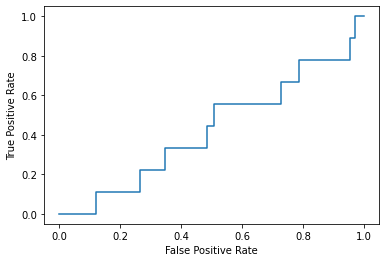

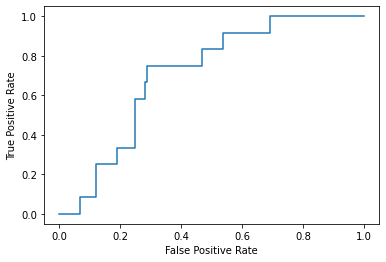

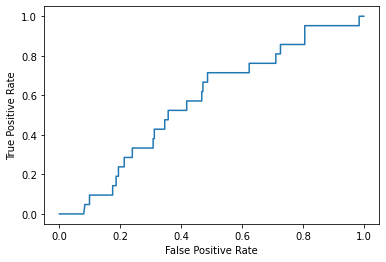

In [34]:


# TODO: Deploy each of the trained models for test-set evaluation
# predictors = [est.deploy(initial_instant_count=1, instance_type='ml.m4.xlarge') 
#               for est in estimators]

if mode == 'fit_hparam':
    
    for i, estimator in enumerate(estimators):
        predictor = estimator.deploy(initial_instance_count=1,
                                     instance_type='ml.m4.xlarge')
        try:
            print(f"Epochs: {epochs[i]}; Dims: {dims[i]}")
            evaluate_lag(lag, test_data, predictor)
            predictor.delete_endpoint()
        except Exception as e:
            predictor.delete_endpoint()
            raise e
        
else:

    predictor_3 = estimators[3].deploy(initial_instance_count=1,
                                       instance_type='ml.m4.xlarge')
    evaluate_lag(3, test_data, predictor_3)
    predictor_3.delete_endpoint()
    
    predictor_5 = estimators[5].deploy(initial_instance_count=1,
                                       instance_type='ml.m4.xlarge')
    evaluate_lag(5, test_data, predictor_5)
    predictor_5.delete_endpoint()
    
    predictor_10 = estimators[10].deploy(initial_instance_count=1,
                                         instance_type='ml.m4.xlarge')
    evaluate_lag(10, test_data, predictor_10)
    predictor_10.delete_endpoint()

Evaluating Lag = 3
Benchmark Performance
Accuracy: 0.9361702127659575
Precision: 0.0
Recall: 0.0
NN Performance
Accuracy: 0.5531914893617021
Precision: 0.09090909090909091
Recall: 0.6666666666666666


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC Score: 0.5429292929292929


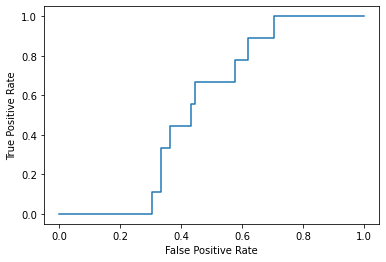

In [16]:
evaluate_lag(3, test_data, predictor_3)

Evaluating Lag = 5
Benchmark Performance
Accuracy: 0.9378238341968912
Precision: 0.0
Recall: 0.0
NN Performance
Accuracy: 0.5647668393782384
Precision: 0.10869565217391304
Recall: 0.8333333333333334
ROC AUC Score: 0.6406537753222837


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


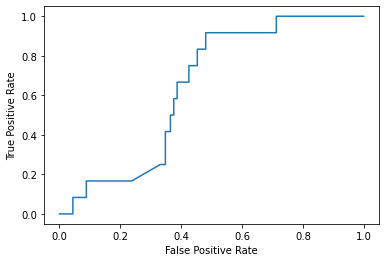

In [17]:
evaluate_lag(5, test_data, predictor_3)

Evaluating Lag = 10
Benchmark Performance
Accuracy: 0.926056338028169
Precision: 0.0
Recall: 0.0
NN Performance
Accuracy: 0.573943661971831
Precision: 0.11538461538461539
Recall: 0.7142857142857143
ROC AUC Score: 0.6070975918884665


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


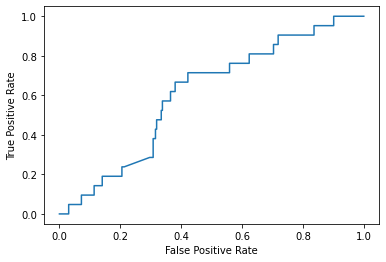

In [18]:
evaluate_lag(10, test_data, predictor_3)

In [19]:
predictor_3.delete_endpoint()
predictor_5.delete_endpoint()
predictor_10.delete_endpoint()